In [1]:
import anndata
import numpy as np
import seaborn as sns

from scroutines.config_plots import *
from scroutines import basicu
import importlib
importlib.reload(basicu)

<module 'scroutines.basicu' from '/data/qlyu/v1/scroutines/scroutines/basicu.py'>

# check features

In [2]:
f = "../../data/jain22_nature_flybrain/scEcRDN.h5ad"
# f = "../../data/jain22_nature_flybrain/scEcRRNAi.h5ad"
# f = "../../data/jain22_nature_flybrain/scHr3RNAi.h5ad"
adata = anndata.read(f)
adata

AnnData object with n_obs × n_vars = 5082 × 17562
    obs: 'replicate', 'genotype', 'time', 'condition', 'celltype', 'cell_condition', 'time_condition', 'nCount_RNA', 'nFeature_RNA'
    var: 'features'

In [3]:
adata = adata[adata.obs['condition']=='WT']
adata

View of AnnData object with n_obs × n_vars = 3596 × 17562
    obs: 'replicate', 'genotype', 'time', 'condition', 'celltype', 'cell_condition', 'time_condition', 'nCount_RNA', 'nFeature_RNA'
    var: 'features'

In [4]:
counts = adata.raw.X
counts

<3596x17562 sparse matrix of type '<class 'numpy.float64'>'
	with 6038323 stored elements in Compressed Sparse Row format>

In [5]:
adata.obs.groupby(['condition', 'time', 'genotype', 'replicate']).size()

condition  time    genotype  replicate
WT         24hAPF  line_391  rep1          57
                             rep2          78
                   line_589  rep1          75
                             rep2          68
                   line_805  rep1          62
                             rep2          67
           48hAPF  line_28   rep1         243
                             rep2         288
                   line_441  rep1         277
                             rep2         295
                   line_897  rep1         335
                             rep2         388
           72hAPF  line_348  rep1         249
                             rep2         250
                   line_383  rep1         149
                             rep2         175
                   line_395  rep1          72
                             rep2          94
           Adult   line_406  rep1         107
                             rep2          88
                   line_461  rep1        

In [6]:
adata.obs.groupby(['condition', 'time', 'celltype', 'replicate']).size()

condition  time    celltype  replicate
WT         24hAPF  L1        rep1          42
                             rep2          48
                   L2        rep1          53
                             rep2          40
                   L3        rep1          47
                             rep2          53
                   L4        rep1          24
                             rep2          41
                   L5        rep1          28
                             rep2          31
           48hAPF  L1        rep1         215
                             rep2         246
                   L2        rep1         221
                             rep2         248
                   L3        rep1          96
                             rep2         102
                   L4        rep1         111
                             rep2         137
                   L5        rep1         212
                             rep2         238
           72hAPF  L1        rep1        

In [7]:
# 4 time points, 5 cell types, 2 replicates each - can we parse the variance?
nt, nc, nr = 4, 5, 2

In [8]:
mat = counts
_types = adata.obs['time']+'_'+adata.obs['celltype']+'_'+adata.obs['replicate']
_xclsts, Xk, Xk_n, Xk_ln = basicu.counts_to_bulk_profiles(mat, _types) 

xclsts = _xclsts.reshape(nt, nc, nr)
pbulks = Xk_ln.reshape(nt, nc, nr, 17562)

In [9]:
pbulks.shape, xclsts.shape

((4, 5, 2, 17562), (4, 5, 2))

In [10]:
def get_eta2_allgenes(nums):
    """
    nums: c1,c2,...,n matrix - ... conditions by n genes
    
    return (eta2, stdv) - vectors one entry for each gene
    """
    nc0, nc1, nc2, ng = nums.shape # (num time points, num rep, num genes)

    nums_m  = np.mean(nums, axis=(0,1,2)) #
    nums_m0 = np.mean(nums, axis=(1,2))   # 0
    nums_m1 = np.mean(nums, axis=(0,2))   # 0
    nums_m2 = np.mean(nums, axis=(0,1))   # 0
    

    # # SSt 
    diff = nums - np.expand_dims(nums_m , axis=(0,1,2))
    SSt  = np.sum(np.power(diff, 2), axis=(0,1,2))  # one for each gene

    # # SSw
    diff = nums - np.expand_dims(nums_m0, axis=(1,2))
    SSw0 = np.sum(np.power(diff, 2), axis=(0,1,2))  # one for each gene
    
    diff = nums - np.expand_dims(nums_m1, axis=(0,2))
    SSw1 = np.sum(np.power(diff, 2), axis=(0,1,2))  # one for each gene
    
    diff = nums - np.expand_dims(nums_m2, axis=(0,1))
    SSw2 = np.sum(np.power(diff, 2), axis=(0,1,2))  # one for each gene

    eta2_0 = (1-(SSw0+1e-6)/(SSt+1e-6))
    eta2_1 = (1-(SSw1+1e-6)/(SSt+1e-6))
    eta2_2 = (1-(SSw2+1e-6)/(SSt+1e-6))
    
    # stdb = np.sqrt((SSt-SSw)/(nt*nr))
    return eta2_0, eta2_1, eta2_2



In [11]:
eta2_t, eta2_c, eta2_r = get_eta2_allgenes(pbulks)

In [64]:
eta2_t.shape

(17562,)

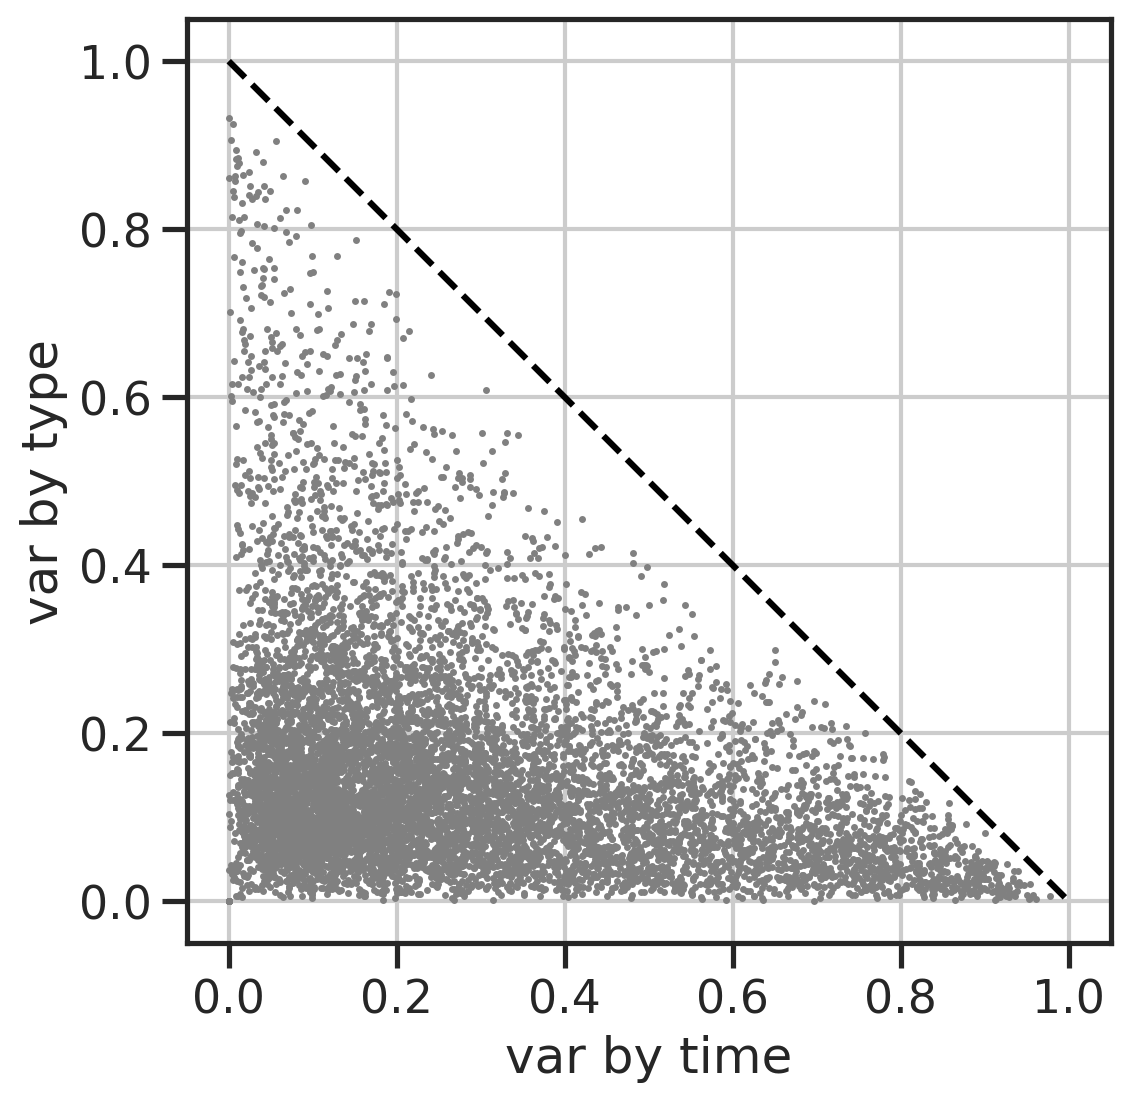

In [12]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(eta2_t, eta2_c, s=1, color='gray')
ax.set_aspect('equal')
ax.set_xlabel('var by time')
ax.set_ylabel('var by type')
ax.plot([0,1], [1,0], color='k', linestyle='--')
plt.show()


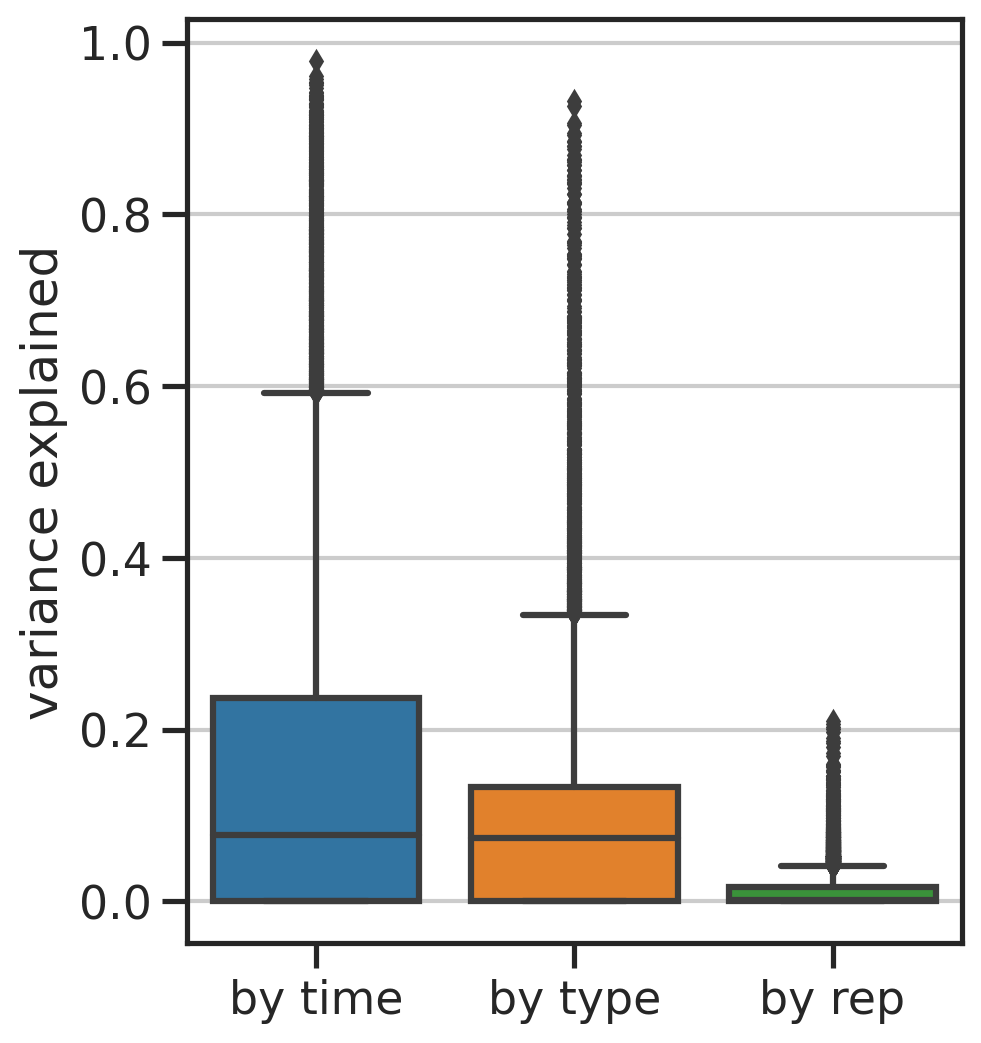

In [13]:
fig, ax = plt.subplots(figsize=(5,6))
sns.boxplot([eta2_t, eta2_c, eta2_r])
ax.set_xticklabels(['by time', 'by type', 'by rep'])
ax.set_ylabel('variance explained')
plt.show()

In [14]:
genes = adata.var.index.values
genes

array(['tdTom', 'Nep3', 'tRNA:Pro-CGG-1-1', ..., 'CG13949', 'CG13950',
       'ninaA'], dtype=object)

In [15]:
'beat-IIa' in genes

True

In [16]:
gi = np.argmax(eta2_t)
gi, genes[gi], eta2_t[gi], eta2_c[gi], eta2_r[gi], eta2_t[gi] + eta2_c[gi] + eta2_r[gi]

(12996,
 'Kr-h1',
 0.9781844715495809,
 0.0063543311952194426,
 5.4528955330535034e-05,
 0.9845933317001309)

In [17]:
gi = np.argmax(eta2_c)
gi, genes[gi], eta2_t[gi], eta2_c[gi], eta2_r[gi], eta2_t[gi] + eta2_c[gi] + eta2_r[gi]

(11579,
 'bru3',
 0.0008222295848191452,
 0.9324041881735115,
 0.012602622586505907,
 0.9458290403448365)

In [18]:
pbulks_g = pbulks[:,:,:,gi]
pbulks_g = np.moveaxis(pbulks_g, 0, -1) # nt, nc, nr -> nc, nr, nt
gname = genes[gi]
print(pbulks_g.shape)

(5, 2, 4)


In [19]:
types = ['L1', 'L2', 'L3', 'L4', 'L5']
ts = [24,48,72,96]

colors = sns.color_palette('Set2', len(types))
colors

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)]

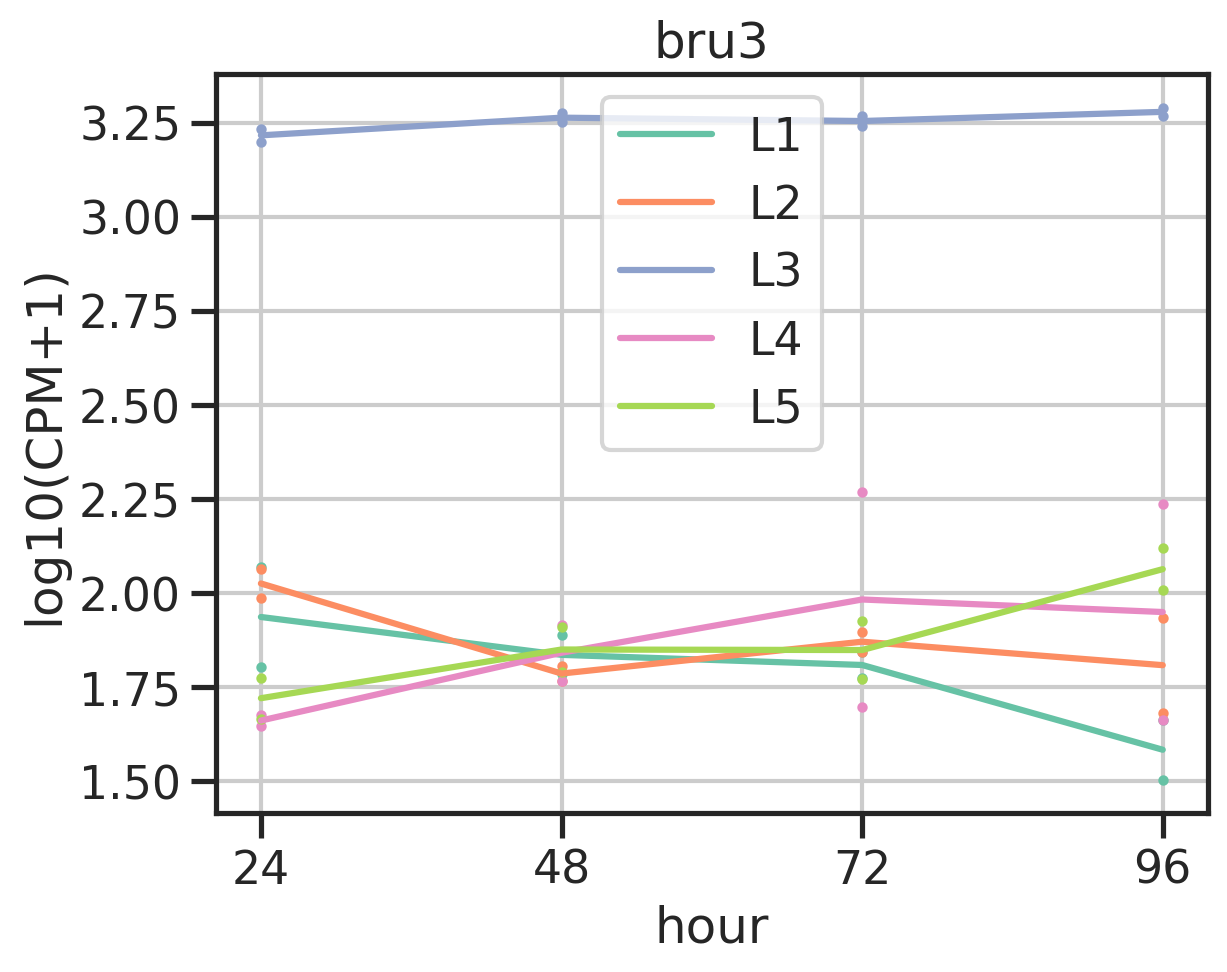

In [20]:

fig, ax = plt.subplots()
ax.set_title(gname)
for i in range(5):
    color = colors[i]
    lbl = types[i]
    ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
    ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
    ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
ax.set_xticks(ts)
ax.legend()
ax.set_ylabel('log10(CPM+1)')
ax.set_xlabel('hour')
plt.show()

# top 10 type specific genes

In [21]:
types = ['L1', 'L2', 'L3', 'L4', 'L5']
ts = [24,48,72,96]

colors = sns.color_palette('Set2', len(types))
colors

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)]

In [22]:
gi_c = np.argsort(eta2_c)[::-1][:10]
# gi, genes[gi], eta2_t[gi], eta2_c[gi], eta2_r[gi], eta2_t[gi] + eta2_c[gi] + eta2_r[gi]

In [23]:
pbulks_sub = pbulks[:,:,:,gi_c]
pbulks_sub = np.swapaxes(pbulks_sub, 0, -1) # nt, nc, nr, ng -> ng, nc, nr, nt
gnames = genes[gi_c]
print(pbulks_g.shape)

(5, 2, 4)


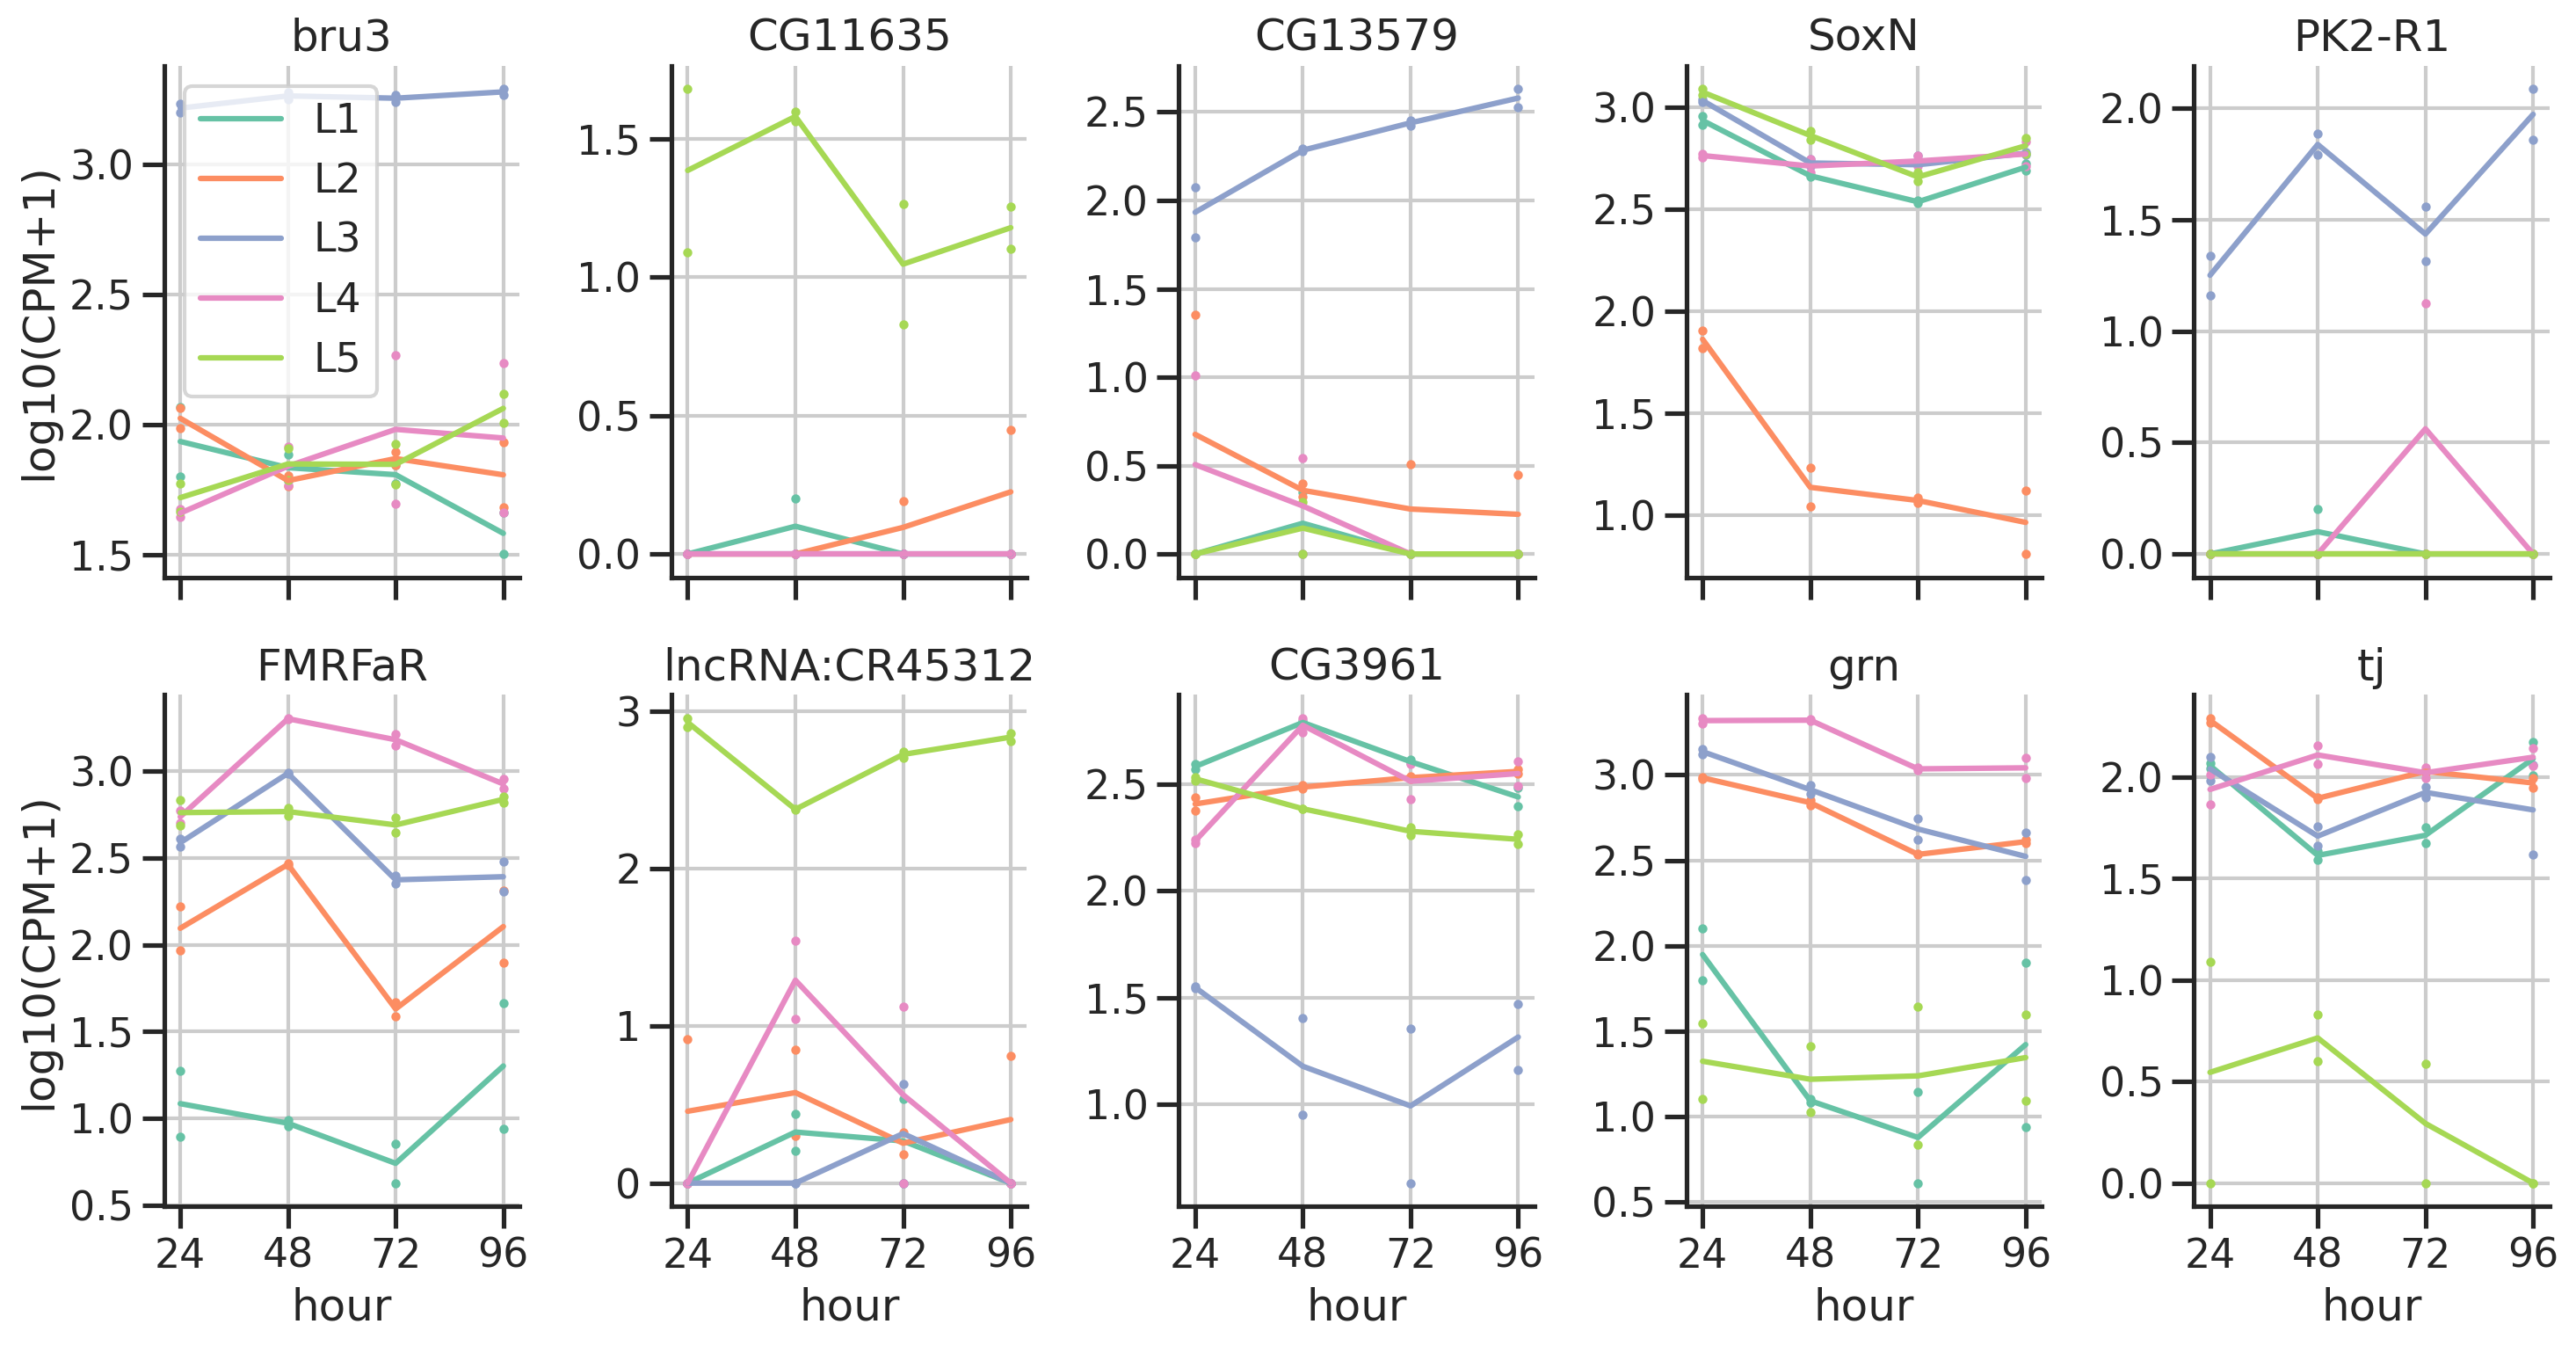

In [24]:
fig, axs = plt.subplots(2,5,figsize=(5*3,2*4), sharex=True)
for j, (pbulks_g, gname, ax) in enumerate(zip(pbulks_sub, gnames, axs.flat)):
    ax.set_title(gname)
    for i in range(5):
        color = colors[i]
        lbl = types[i]
        ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
        ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
        ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
    ax.set_xticks(ts)
    sns.despine(ax=ax)
    if j == 0:
        ax.legend()
    if j % 5 == 0:
        ax.set_ylabel('log10(CPM+1)')
    if j >= 5:
        ax.set_xlabel('hour')
    
fig.tight_layout()
plt.show()

# top 10 time specific genes

In [25]:
types = ['L1', 'L2', 'L3', 'L4', 'L5']
ts = [24,48,72,96]

colors = sns.color_palette('Set2', len(types))
colors

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235)]

In [26]:
gi_t = np.argsort(eta2_t)[::-1][:10]
# gi, genes[gi], eta2_t[gi], eta2_c[gi], eta2_r[gi], eta2_t[gi] + eta2_c[gi] + eta2_r[gi]

In [27]:
pbulks_sub = pbulks[:,:,:,gi_t]
pbulks_sub = np.swapaxes(pbulks_sub, 0, -1) # nt, nc, nr, ng -> ng, nc, nr, nt
gnames = genes[gi_t]
print(pbulks_g.shape)

(5, 2, 4)


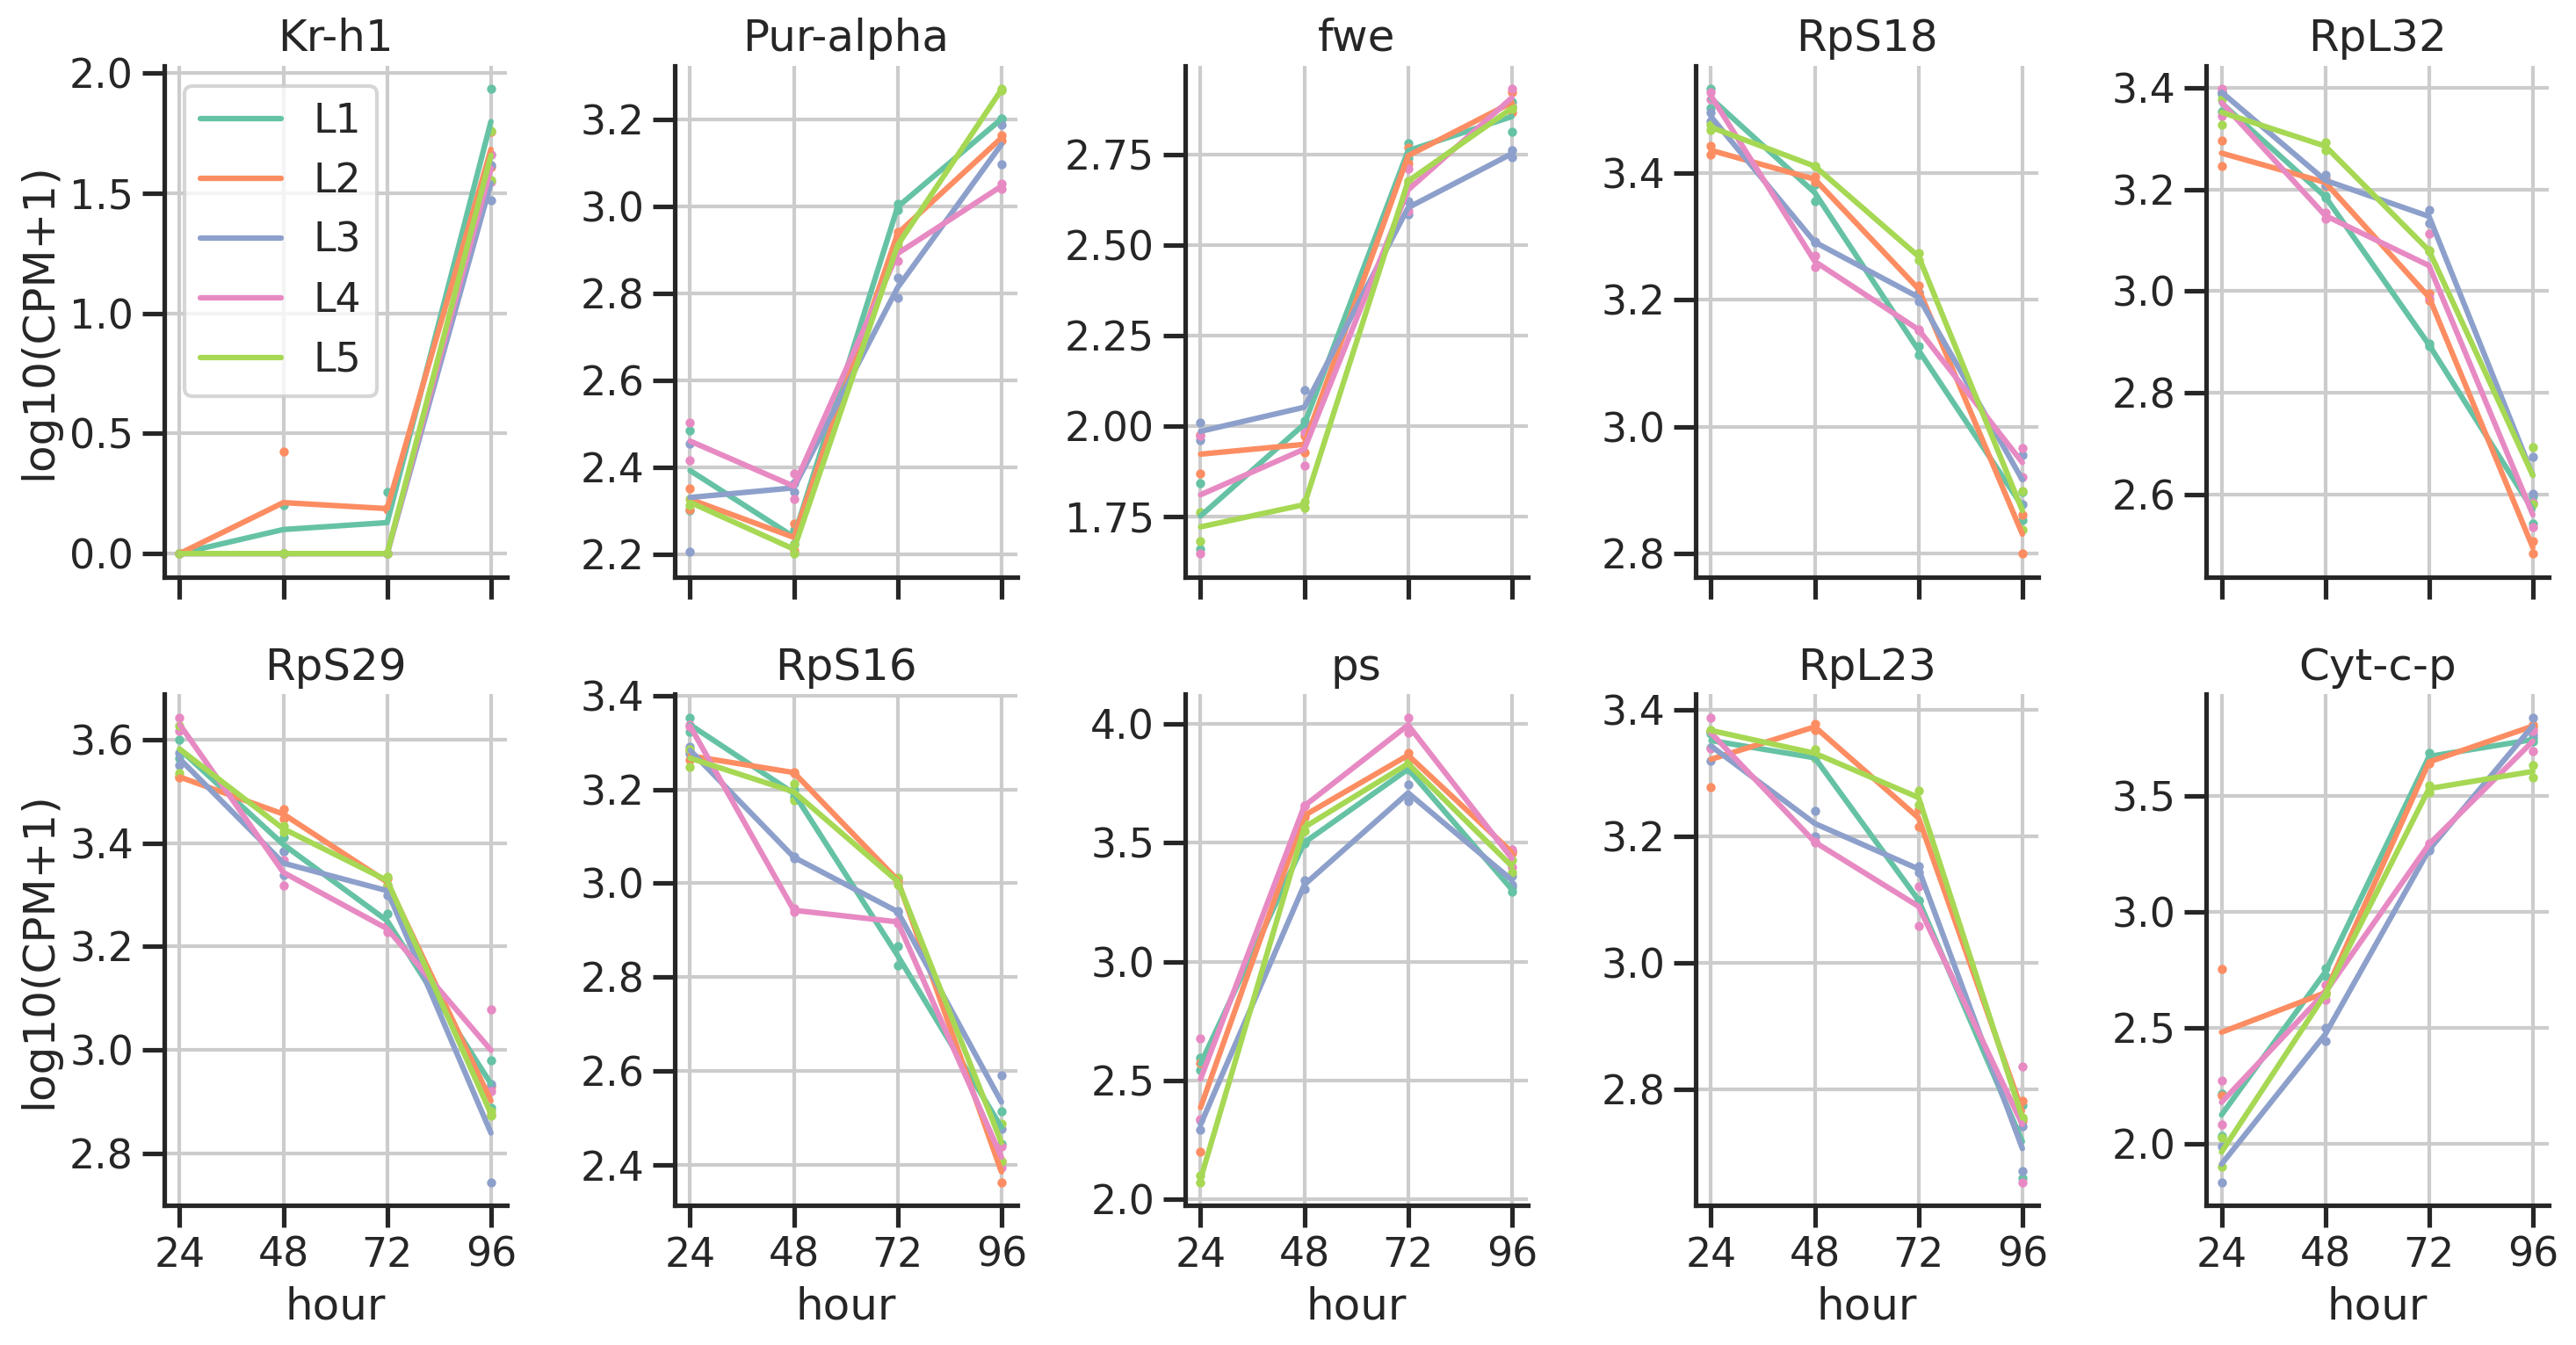

In [28]:
fig, axs = plt.subplots(2,5,figsize=(5*3,2*4), sharex=True)
for j, (pbulks_g, gname, ax) in enumerate(zip(pbulks_sub, gnames, axs.flat)):
    ax.set_title(gname)
    for i in range(5):
        color = colors[i]
        lbl = types[i]
        ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
        ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
        ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
    ax.set_xticks(ts)
    sns.despine(ax=ax)
    if j == 0:
        ax.legend()
    if j % 5 == 0:
        ax.set_ylabel('log10(CPM+1)')
    if j >= 5:
        ax.set_xlabel('hour')
    
fig.tight_layout()
plt.show()

In [29]:
# cond = np.logical_and(np.abs(eta2_t-0.5) < 0.1, np.abs(eta2_c-0.5) < 0.1)

cond = np.logical_and(eta2_t+eta2_c>0.8, np.abs(eta2_t-0.5)<0.2)
cond = np.logical_and(cond, np.abs(eta2_c-0.5)<0.2)
gi_ct = np.arange(len(genes))[cond]
# gi_ct = np.array([g for g in gi_ct if (g not in gi_c and g not in gi_t)])
gi_ct.shape

(42,)

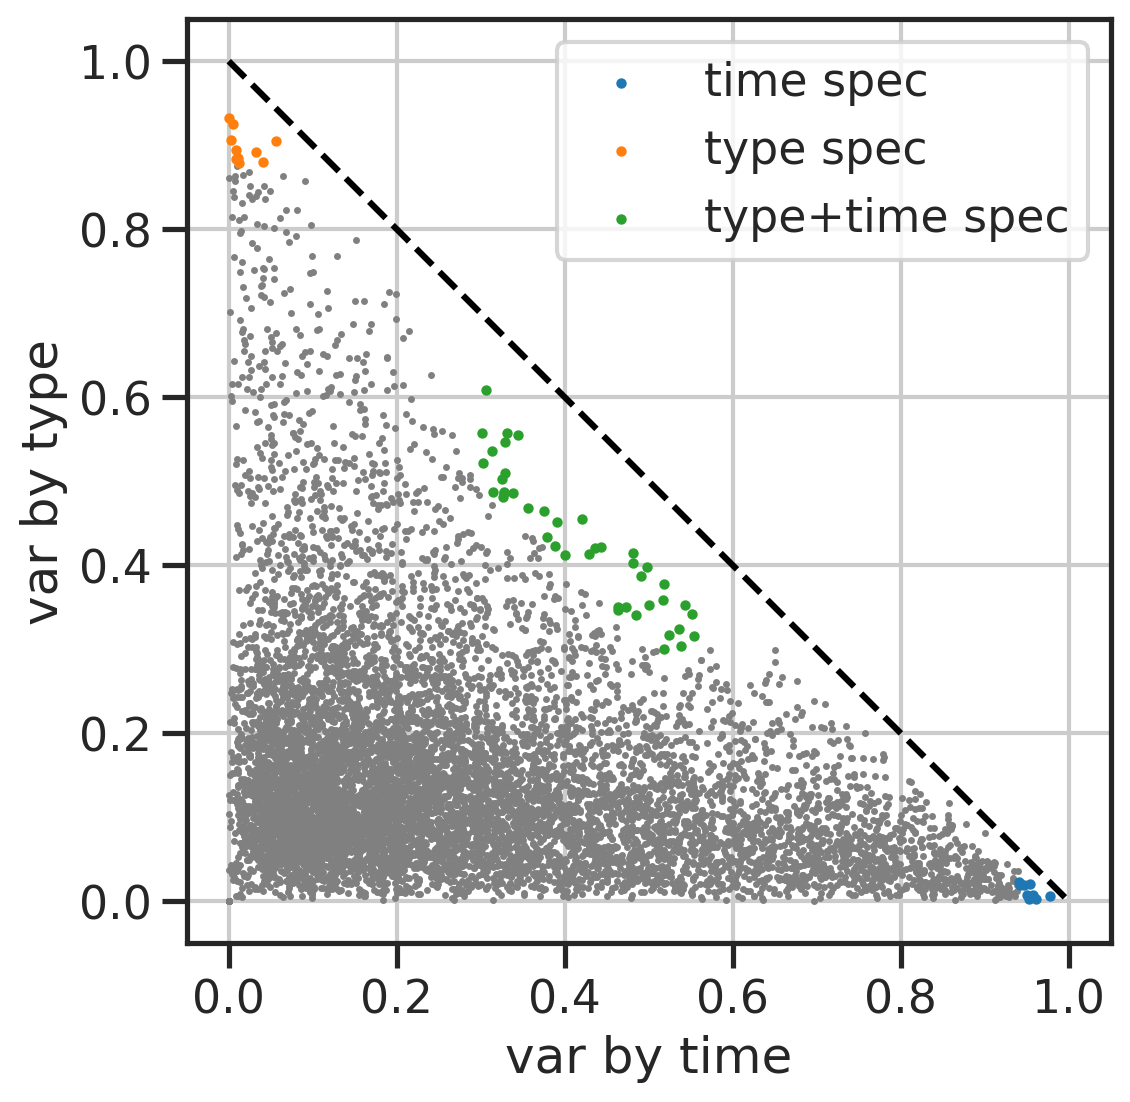

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(eta2_t, eta2_c, s=1, color='gray')
ax.scatter(eta2_t[gi_t], eta2_c[gi_t], s=5, color='C0', label='time spec')
ax.scatter(eta2_t[gi_c], eta2_c[gi_c], s=5, color='C1', label='type spec')
ax.scatter(eta2_t[gi_ct], eta2_c[gi_ct], s=5, color='C2', label='type+time spec')
ax.set_aspect('equal')
ax.set_xlabel('var by time')
ax.set_ylabel('var by type')
ax.legend()
ax.plot([0,1], [1,0], color='k', linestyle='--')
plt.show()

In [31]:
pbulks_sub = pbulks[:,:,:,gi_ct]
pbulks_sub = np.swapaxes(pbulks_sub, 0, -1) # nt, nc, nr, ng -> ng, nc, nr, nt
gnames = genes[gi_ct]
print(pbulks_g.shape)

(5, 2, 4)


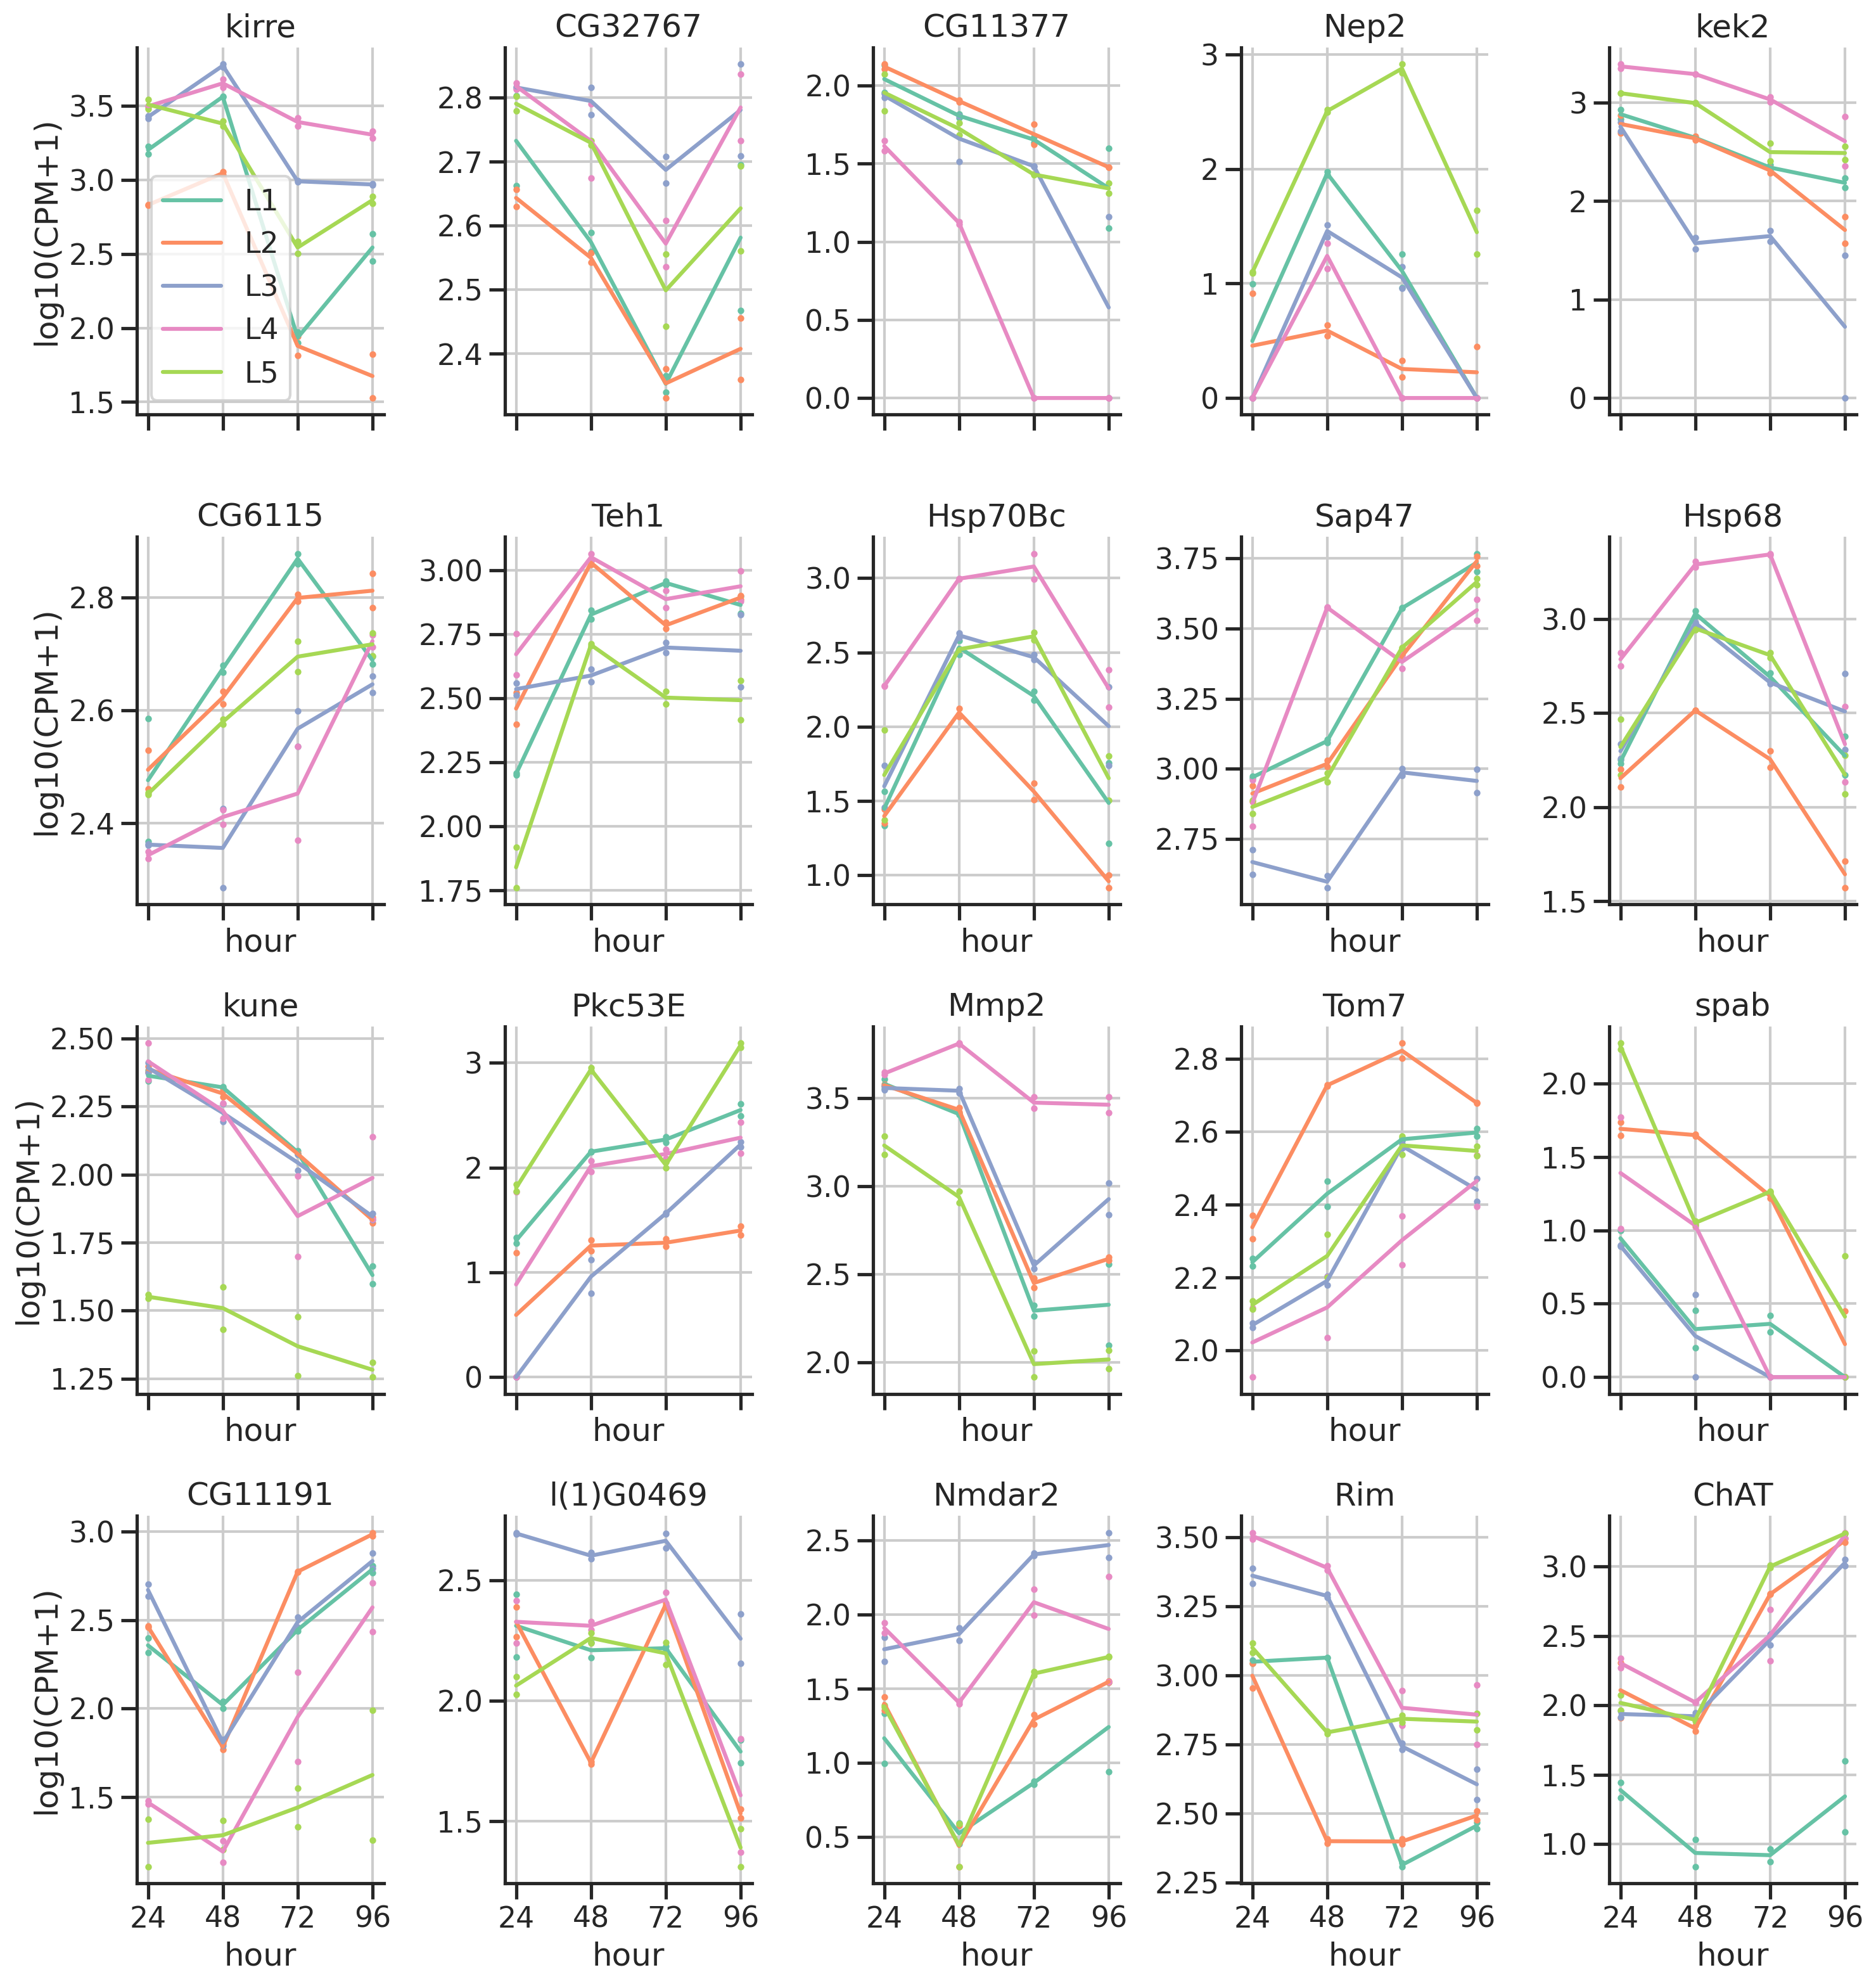

In [32]:
fig, axs = plt.subplots(4,5,figsize=(5*3,4*4), sharex=True)
for j, (pbulks_g, gname, ax) in enumerate(zip(pbulks_sub, gnames, axs.flat)):
    ax.set_title(gname)
    for i in range(5):
        color = colors[i]
        lbl = types[i]
        ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
        ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
        ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
    ax.set_xticks(ts)
    sns.despine(ax=ax)
    if j == 0:
        ax.legend()
    if j % 5 == 0:
        ax.set_ylabel('log10(CPM+1)')
    if j >= 5:
        ax.set_xlabel('hour')
    
fig.tight_layout()
plt.show()

In [44]:
gi1 = basicu.get_index_from_array(genes, ['EcR'])
gi2 = basicu.get_index_from_array(genes, ['Hr3'])
gi3 = basicu.get_index_from_array(genes, ['beat-IIa'])

gi1, gi2, gi3

(array([5041]), array([6753]), array([3575]))

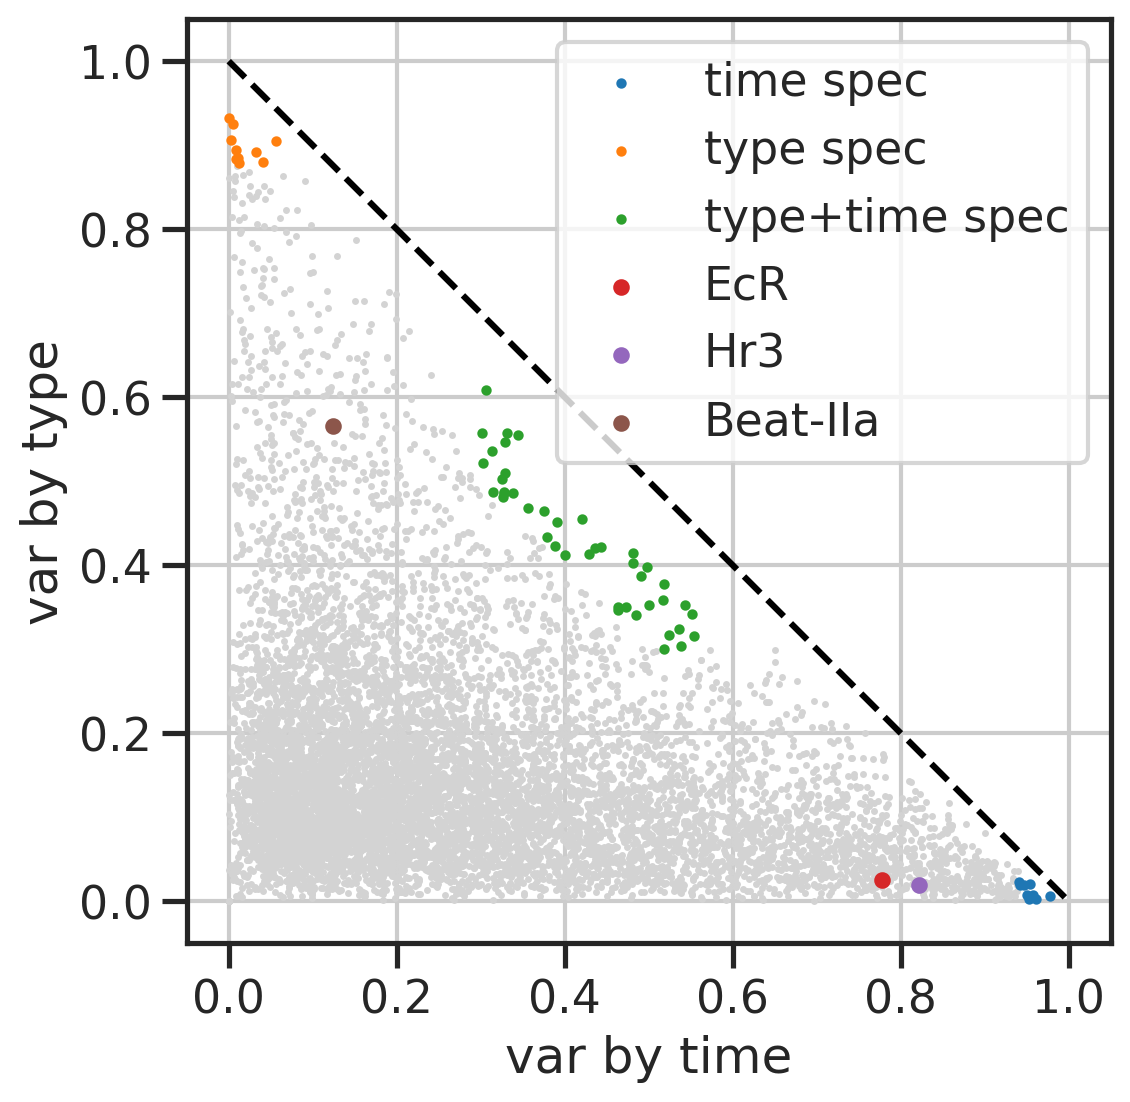

In [62]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(eta2_t, eta2_c, s=1, color='lightgray')
ax.scatter(eta2_t[gi_t], eta2_c[gi_t], s=5, color='C0', label='time spec')
ax.scatter(eta2_t[gi_c], eta2_c[gi_c], s=5, color='C1', label='type spec')
ax.scatter(eta2_t[gi_ct], eta2_c[gi_ct], s=5, color='C2', label='type+time spec')
ax.scatter(eta2_t[gi1], eta2_c[gi1], s=20, color='C3', label='EcR')
ax.scatter(eta2_t[gi2], eta2_c[gi2], s=20, color='C4', label='Hr3')
ax.scatter(eta2_t[gi3], eta2_c[gi3], s=20, color='C5', label='Beat-IIa')
ax.set_aspect('equal')
ax.set_xlabel('var by time')
ax.set_ylabel('var by type')
ax.legend()
ax.plot([0,1], [1,0], color='k', linestyle='--')
plt.show()

(1, 5, 2, 4)


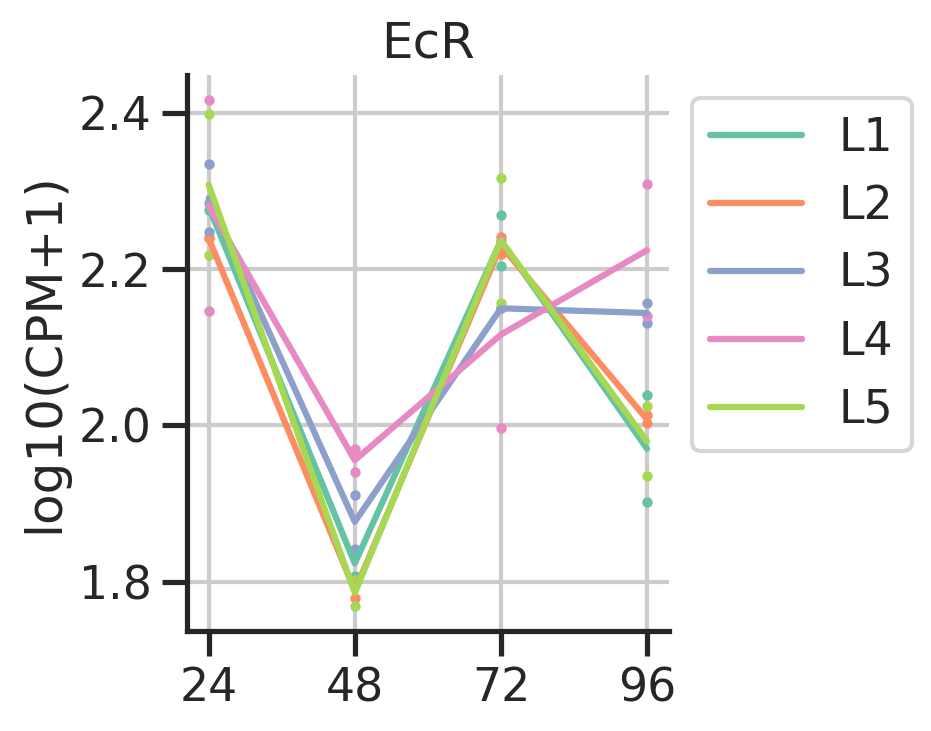

(1, 5, 2, 4)


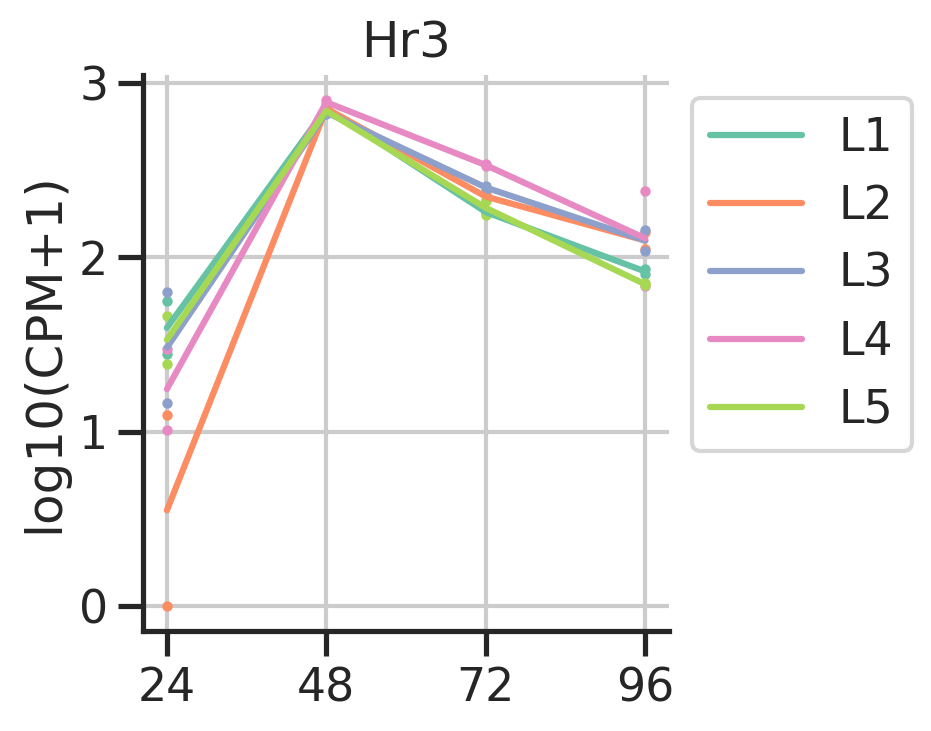

(1, 5, 2, 4)


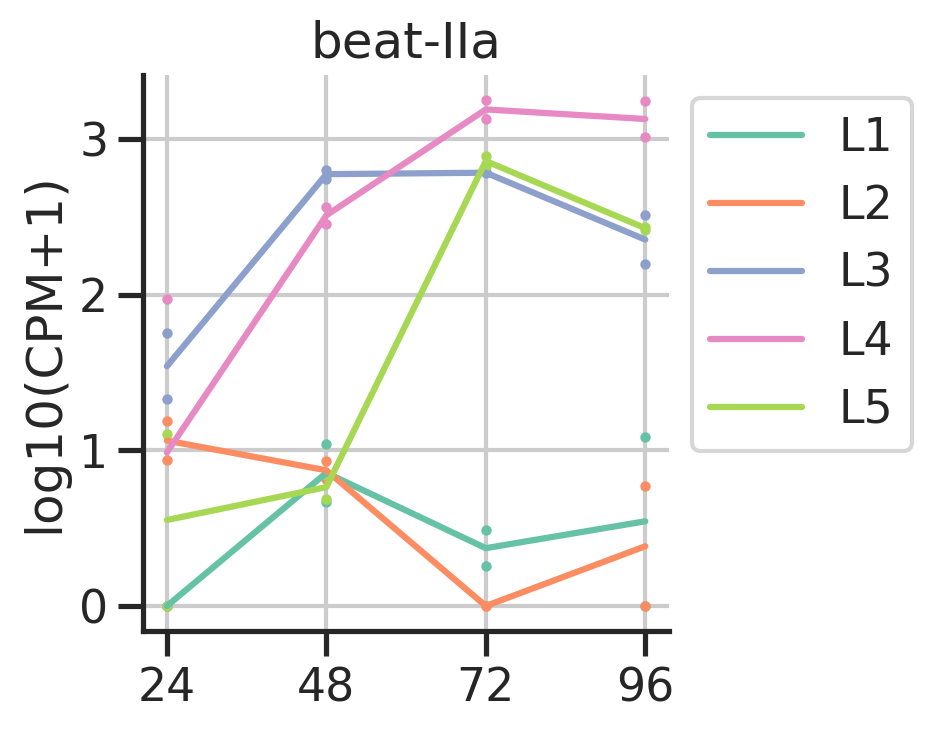

In [61]:
for gi in [gi1, gi2, gi3]:
    pbulks_sub = pbulks[:,:,:,gi] #, axis=3)
    pbulks_sub = np.swapaxes(pbulks_sub, 0, -1) # nt, nc, nr, ng -> ng, nc, nr, nt
    gnames = genes[gi]
    print(pbulks_sub.shape)

    fig, axs = plt.subplots(1,1,figsize=(1*5,1*4), sharex=True)
    for j, (pbulks_g, gname, ax) in enumerate(zip(pbulks_sub, gnames, [axs])):
        ax.set_title(gname)
        for i in range(5):
            color = colors[i]
            lbl = types[i]
            ax.plot(ts, np.mean(pbulks_g[i], axis=0), color=color, label=lbl)
            ax.scatter(ts, pbulks_g[i][0], s=5, color=color)
            ax.scatter(ts, pbulks_g[i][1], s=5, color=color)
        ax.set_xticks(ts)
        sns.despine(ax=ax)
        if j == 0:
            ax.legend(bbox_to_anchor=(1,1))
        if j % 5 == 0:
            ax.set_ylabel('log10(CPM+1)')
        if j >= 5:
            ax.set_xlabel('hour')

    fig.tight_layout()
    plt.show()